In [ ]:
!pip install textblob nltk vaderSentiment
#nltk.download('movie_reviews')
nltk.download('punkt')

In [1]:
import pandas as pd
import torch
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import numpy as np

device = 0 if torch.cuda.is_available() else -1
device

-1

In [2]:
filepath = r"combined_df.csv"
df = pd.read_csv(filepath, dtype=str).sort_values(by='Survey ID')
#df
df['Combined Text'] = df['Combined Text'].astype(str)

In [3]:
def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def textblob_naive_bayes_sentiment(text):
    blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    return blob.sentiment.classification

def nltk_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']

In [4]:
sampled_df = df.sample(n=1000, random_state=42)

In [23]:
sampled_df['TextBlob_Sentiment'] = sampled_df['Combined Text'].apply(textblob_sentiment)

sampled_df

,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,Printer Family,Model Name,Combined Text,Ink Supply Type,token_count,Response Date,Month of Response Date,predicted_level1,TextBlob_Sentiment
25588,332504286,HP DeskJet Ink Advantage 2774 All-in-One Printer,BR,8,HPS Surveys,Portuguese (Brazil),NaN,NaN,Supplies - Ink,Obelisk,Taccola,HP DeskJet Ink Advantage 2779 All-in-One Printer,Because I have some difficulties to use it and...,IPH,27,2023-08-22 04:35:21,2023-08-01 00:00:00,Customer experience & expectation,-0.193750
30810,335441755,HP 951XL High Yield Yellow Original Ink Cartridge,US,10,Web Reviews,English,Office Depot,5,Supplies - Ink,Nesta+,NaN,HP 951XL High Yield Yellow Original Ink Cartridge,Bought a few weeks ago. Easy to install. Excel...,IIC,10,2023-08-23 17:24:50,2023-08-01 00:00:00,General satisfied,0.411111
61411,355168008,HP 952XL High Yield Black Original Ink Cartridge,US,10,Web Reviews,English,Office Depot,5,Supplies - Ink,Supernesta,NaN,HP 952XL High Yield Black Original Ink Cartridge,Only recommend original HP ink! Best ink!,IIC,7,2023-12-19 13:07:20,2023-12-01 00:00:00,Others,0.489583
49186,347332806,HP ENVY 6055e All-in-One Printer,US,1,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,Vasari Yeti,HP ENVY 6055e All-in-One Printer,IT was fine until it wasn't. The copies were g...,IPH,44,2023-11-14 19:04:26,2023-11-01 00:00:00,Cartridge Problem,-0.131667
42104,342918354,HP ENVY Photo 7155 All-in-One Printer,US,1,HPS Surveys,English,NaN,NaN,Supplies - Ink,Centaur,Palermo,HP ENVY Photo 7155 All-in-One Printer,The HP Ink service has charged me on 2 differe...,IPH,72,2023-10-20 22:16:18,2023-10-01 00:00:00,Customer experience & expectation,-0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93038,381756644,HP 62 Black Original Ink Cartridge,US,10,Web Reviews,English,Amazon US,5,Supplies - Ink,Minotaur,NaN,HP 62 Black Original Ink Cartridge,Never any issues with HP Inkjets. No leaking o...,IPH,18,2024-04-11 01:00:00,2024-04-01 00:00:00,Others,0.400000
78001,368105146,HP ENVY Inspire 7255e All-in-One Printer,US,10,HPS Surveys,English,NaN,NaN,Supplies - Ink,Centaur,Novelli Yeti,HP ENVY Inspire 7255e All-in-One Printer,Easy to use. Good color. I like the ink cartri...,IPH,11,2024-03-23 12:30:51,2024-03-01 00:00:00,General satisfied,0.566667
46188,345836499,HP DeskJet 3755 All-in-One Printer,US,8,HPS Surveys,English,NaN,NaN,Supplies - Ink,Dolmen Refresh,Lhasa,HP DeskJet 3755 All-in-One Printer,Very good basic printer and works well for me....,IPH,26,2023-11-04 09:24:02,2023-11-01 00:00:00,"General satisfied, Print quality",0.352500
83085,370556058,HP OfficeJet Pro 8022e All-in-One Printer,DE,0,HPS Surveys,German,NaN,NaN,Supplies - Ink,Cedella,Malbec Yeti,HP OfficeJet Pro 8022e All-in-One Printer,Printer cartridges are far too expensive,IIC,6,2024-03-18 13:04:58,2024-03-01 00:00:00,Cost,-0.200000


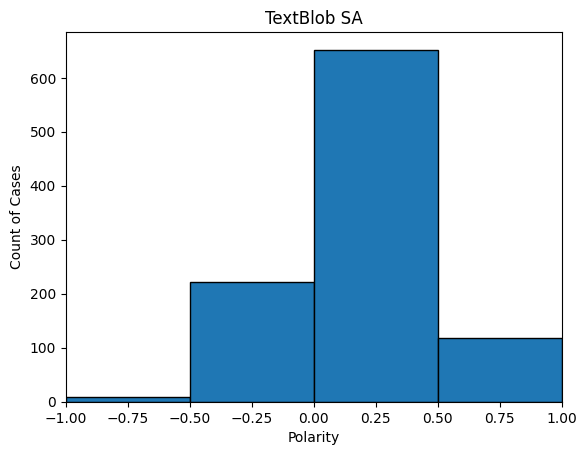

In [24]:
import matplotlib.pyplot as plt

# Define the bins
bins = [-1, -0.5, 0, 0.5, 1]

# Create the histogram
hist, bin_edges = np.histogram(sampled_df['TextBlob_Sentiment'], bins=bins)

# Plot the bar chart
plt.bar(bin_edges[:-1], hist, width=0.5, edgecolor='black', align='edge')

# Set the labels and title
plt.xlabel('Polarity')
plt.ylabel('Count of Cases')
plt.title('TextBlob SA')

# Set the x-axis limits
plt.xlim(-1, 1)

# Show the plot
plt.show()

In [8]:
sampled_df['TextBlob_NaiveBayes_Sentiment'] = sampled_df['Combined Text'].apply(textblob_naive_bayes_sentiment)
sampled_df

,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,Printer Family,Model Name,Combined Text,Ink Supply Type,token_count,Response Date,Month of Response Date,predicted_level1,NLTK_Vader_Sentiment,TextBlob_NaiveBayes_Sentiment
25588,332504286,HP DeskJet Ink Advantage 2774 All-in-One Printer,BR,8,HPS Surveys,Portuguese (Brazil),NaN,NaN,Supplies - Ink,Obelisk,Taccola,HP DeskJet Ink Advantage 2779 All-in-One Printer,Because I have some difficulties to use it and...,IPH,27,2023-08-22 04:35:21,2023-08-01 00:00:00,Customer experience & expectation,-0.6124,pos
30810,335441755,HP 951XL High Yield Yellow Original Ink Cartridge,US,10,Web Reviews,English,Office Depot,5,Supplies - Ink,Nesta+,NaN,HP 951XL High Yield Yellow Original Ink Cartridge,Bought a few weeks ago. Easy to install. Excel...,IIC,10,2023-08-23 17:24:50,2023-08-01 00:00:00,General satisfied,0.7650,pos
61411,355168008,HP 952XL High Yield Black Original Ink Cartridge,US,10,Web Reviews,English,Office Depot,5,Supplies - Ink,Supernesta,NaN,HP 952XL High Yield Black Original Ink Cartridge,Only recommend original HP ink! Best ink!,IIC,7,2023-12-19 13:07:20,2023-12-01 00:00:00,Others,0.8619,pos
49186,347332806,HP ENVY 6055e All-in-One Printer,US,1,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,Vasari Yeti,HP ENVY 6055e All-in-One Printer,IT was fine until it wasn't. The copies were g...,IPH,44,2023-11-14 19:04:26,2023-11-01 00:00:00,Cartridge Problem,-0.9050,neg
42104,342918354,HP ENVY Photo 7155 All-in-One Printer,US,1,HPS Surveys,English,NaN,NaN,Supplies - Ink,Centaur,Palermo,HP ENVY Photo 7155 All-in-One Printer,The HP Ink service has charged me on 2 differe...,IPH,72,2023-10-20 22:16:18,2023-10-01 00:00:00,Customer experience & expectation,-0.5859,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93038,381756644,HP 62 Black Original Ink Cartridge,US,10,Web Reviews,English,Amazon US,5,Supplies - Ink,Minotaur,NaN,HP 62 Black Original Ink Cartridge,Never any issues with HP Inkjets. No leaking o...,IPH,18,2024-04-11 01:00:00,2024-04-01 00:00:00,Others,-0.2023,neg
78001,368105146,HP ENVY Inspire 7255e All-in-One Printer,US,10,HPS Surveys,English,NaN,NaN,Supplies - Ink,Centaur,Novelli Yeti,HP ENVY Inspire 7255e All-in-One Printer,Easy to use. Good color. I like the ink cartri...,IPH,11,2024-03-23 12:30:51,2024-03-01 00:00:00,General satisfied,0.8074,pos
46188,345836499,HP DeskJet 3755 All-in-One Printer,US,8,HPS Surveys,English,NaN,NaN,Supplies - Ink,Dolmen Refresh,Lhasa,HP DeskJet 3755 All-in-One Printer,Very good basic printer and works well for me....,IPH,26,2023-11-04 09:24:02,2023-11-01 00:00:00,"General satisfied, Print quality",0.8070,pos
83085,370556058,HP OfficeJet Pro 8022e All-in-One Printer,DE,0,HPS Surveys,German,NaN,NaN,Supplies - Ink,Cedella,Malbec Yeti,HP OfficeJet Pro 8022e All-in-One Printer,Printer cartridges are far too expensive,IIC,6,2024-03-18 13:04:58,2024-03-01 00:00:00,Cost,0.0000,pos


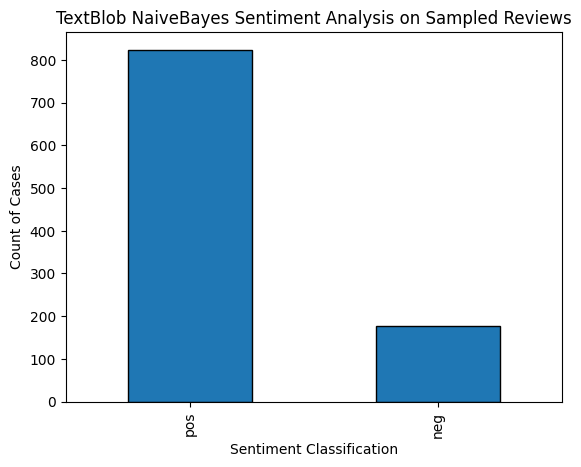

In [11]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment classification
sentiment_counts = sampled_df['TextBlob_NaiveBayes_Sentiment'].value_counts()

# Plot the bar chart
sentiment_counts.plot(kind='bar', edgecolor='black')

# Set the labels and title
plt.xlabel('Sentiment Classification')
plt.ylabel('Count of Cases')
plt.title('TextBlob NaiveBayes Sentiment Analysis on Sampled Reviews')

# Show the plot
plt.show()

In [9]:
sampled_df['NLTK_Vader_Sentiment'] = sampled_df['Combined Text'].apply(nltk_vader_sentiment)
sampled_df

,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,Printer Family,Model Name,Combined Text,Ink Supply Type,token_count,Response Date,Month of Response Date,predicted_level1,NLTK_Vader_Sentiment,TextBlob_NaiveBayes_Sentiment
25588,332504286,HP DeskJet Ink Advantage 2774 All-in-One Printer,BR,8,HPS Surveys,Portuguese (Brazil),NaN,NaN,Supplies - Ink,Obelisk,Taccola,HP DeskJet Ink Advantage 2779 All-in-One Printer,Because I have some difficulties to use it and...,IPH,27,2023-08-22 04:35:21,2023-08-01 00:00:00,Customer experience & expectation,-0.6124,pos
30810,335441755,HP 951XL High Yield Yellow Original Ink Cartridge,US,10,Web Reviews,English,Office Depot,5,Supplies - Ink,Nesta+,NaN,HP 951XL High Yield Yellow Original Ink Cartridge,Bought a few weeks ago. Easy to install. Excel...,IIC,10,2023-08-23 17:24:50,2023-08-01 00:00:00,General satisfied,0.7650,pos
61411,355168008,HP 952XL High Yield Black Original Ink Cartridge,US,10,Web Reviews,English,Office Depot,5,Supplies - Ink,Supernesta,NaN,HP 952XL High Yield Black Original Ink Cartridge,Only recommend original HP ink! Best ink!,IIC,7,2023-12-19 13:07:20,2023-12-01 00:00:00,Others,0.8619,pos
49186,347332806,HP ENVY 6055e All-in-One Printer,US,1,HPS Surveys,English,NaN,NaN,Supplies - Ink,Obelisk,Vasari Yeti,HP ENVY 6055e All-in-One Printer,IT was fine until it wasn't. The copies were g...,IPH,44,2023-11-14 19:04:26,2023-11-01 00:00:00,Cartridge Problem,-0.9050,neg
42104,342918354,HP ENVY Photo 7155 All-in-One Printer,US,1,HPS Surveys,English,NaN,NaN,Supplies - Ink,Centaur,Palermo,HP ENVY Photo 7155 All-in-One Printer,The HP Ink service has charged me on 2 differe...,IPH,72,2023-10-20 22:16:18,2023-10-01 00:00:00,Customer experience & expectation,-0.5859,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93038,381756644,HP 62 Black Original Ink Cartridge,US,10,Web Reviews,English,Amazon US,5,Supplies - Ink,Minotaur,NaN,HP 62 Black Original Ink Cartridge,Never any issues with HP Inkjets. No leaking o...,IPH,18,2024-04-11 01:00:00,2024-04-01 00:00:00,Others,-0.2023,neg
78001,368105146,HP ENVY Inspire 7255e All-in-One Printer,US,10,HPS Surveys,English,NaN,NaN,Supplies - Ink,Centaur,Novelli Yeti,HP ENVY Inspire 7255e All-in-One Printer,Easy to use. Good color. I like the ink cartri...,IPH,11,2024-03-23 12:30:51,2024-03-01 00:00:00,General satisfied,0.8074,pos
46188,345836499,HP DeskJet 3755 All-in-One Printer,US,8,HPS Surveys,English,NaN,NaN,Supplies - Ink,Dolmen Refresh,Lhasa,HP DeskJet 3755 All-in-One Printer,Very good basic printer and works well for me....,IPH,26,2023-11-04 09:24:02,2023-11-01 00:00:00,"General satisfied, Print quality",0.8070,pos
83085,370556058,HP OfficeJet Pro 8022e All-in-One Printer,DE,0,HPS Surveys,German,NaN,NaN,Supplies - Ink,Cedella,Malbec Yeti,HP OfficeJet Pro 8022e All-in-One Printer,Printer cartridges are far too expensive,IIC,6,2024-03-18 13:04:58,2024-03-01 00:00:00,Cost,0.0000,pos


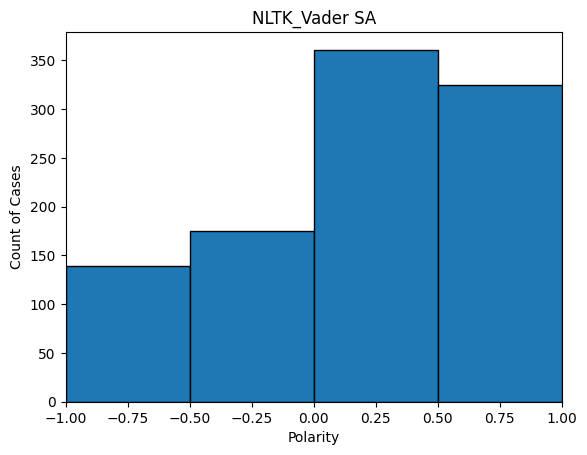

In [7]:
import matplotlib.pyplot as plt

# Define the bins
bins = [-1, -0.5, 0, 0.5, 1]

# Create the histogram
hist, bin_edges = np.histogram(sampled_df['NLTK_Vader_Sentiment'], bins=bins)

# Plot the bar chart
plt.bar(bin_edges[:-1], hist, width=0.5, edgecolor='black', align='edge')

# Set the labels and title
plt.xlabel('Polarity')
plt.ylabel('Count of Cases')
plt.title('NLTK_Vader SA')

# Set the x-axis limits
plt.xlim(-1, 1)

# Show the plot
plt.show()

In [12]:
sampled_df.to_csv('sentiment_analysis_output[WD].csv', index=False)